# Assignment 2A : Analysing Flight-delays Data

Name : Pichaphop Sunthornjittanon

Student ID : 31258301

# Table of contents<a class="anchor" id="table"></a>



* [1.Data Loading, Cleaning, Labelling, and Exploration (45%)](#1)
* [1.1 Data loading (5%)](#1.1)
* [1.2 Data cleaning (15%)](#1.2)
* [1.3 Data Labelling (15%)](#1.3)
* [1.4 Data Exploration / Exploratory Analysis (10%)](#1.4)


* [2.Feature extraction and ML Training (55%)](#2)
* [2.1 Discuss the feature selection and prepare the feature columns(10%)](#2.1)
* [2.2 Preparing any Spark ML Transformers/ Estimators for features and models(10-15%)](#2.2)
* [2.3 Preparing the training and testing data (5%)](#2.3)
* [2.4 Training and evaluating models (30%)](#2.4)


# 1.Data Loading, Cleaning, Labelling, and Exploration (45%)<a class="anchor" id="1"></a>

In this section, you will prepare the data (loading and cleaning), performing data exploration
and

## 1.1 Data loading (5%)<a class="anchor" id="1.1"></a>

1. Write the code to get an object using SparkSession, which tells Spark how to access a
cluster. To create a SparkSession you first need to build a SparkConf object that
contains information about your application. Give an appropriate name for your
application and run Spark locally with as many working processors as logical cores on
your machine.




In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"


# Assign the name to be shown on the Spark cluster UI page
app_name = "Analysing Flight Delay Data"

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL


# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

#  Create SparkContext object using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')


2. Read the 20 files of “flight*.csv” file into a single Spark DataFrame namely
flightsRawDf using spark.read.csv with both header and inferSchema attributes are
set to True. Display the total number of flightsRawDf rows.


In [2]:
## Load csv file using spark session
flightsRawDf  = spark.read.csv('data/flight*.csv', header=True, inferSchema=True)

# Display the total number of flightsRawDf rows
print('The total number of flightsRawDf row is ',flightsRawDf.count())

# Display the total number of flightsRawDf columns
print('The total number of flightsRawDf column is ',len(flightsRawDf.columns))

The total number of flightsRawDf row is  582184
The total number of flightsRawDf column is  31


3. Obtain the list of columns from flightsRawDf and name this variable as allColumnFlights.

In [3]:
# Obtain the list of columns from flightsRawDf and name this variable as allColumnFlights.
allColumnFlights = flightsRawDf.columns
print(allColumnFlights)

['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


## 1.2  Data cleaning (15%)<a class="anchor" id="1.2"></a>

1. Check for missing values (NaN and Null) in all columns, display the number of
missing values for each column. Do you see any pattern in how values are missing in
the data? E.g. You can take the top two columns with the highest percentage of
missing values and examine if the values are missing completely at random?

In [4]:
from pyspark.sql.functions import isnan, when, count, col

# Display the number of missing values in each column
flightsRawDf.select([count(when
                           (isnan(c) | col(c).isNull(), c)).alias(c) 
                     for c in flightsRawDf.columns]).\
                                            toPandas().transpose().\
                                            rename(columns ={0:'number_of_missing_values'}).\
                                            sort_values(by='number_of_missing_values',
                                                        ascending = False)

,number_of_missing_values
CANCELLATION_REASON,573213
WEATHER_DELAY,475831
LATE_AIRCRAFT_DELAY,475831
AIRLINE_DELAY,475831
SECURITY_DELAY,475831
AIR_SYSTEM_DELAY,475831
AIR_TIME,10455
ARRIVAL_DELAY,10455
ELAPSED_TIME,10455
WHEELS_ON,9257


#### Answer

- Most of CANCELLATION_REASON data was missing (About 98.5 % of total records)
- The numbers of missing value of WEATHER,LATE AIRCRAFT,AIRLINE,SECURITY,AIR_SYSTEM delays were equivalent. In other words, the records had whether all of those delays or all of them as null so the values are not missing completely at ranom.

2. Remove some columns and rows in the flightsRawDf using threshold values. Please
do the following tasks :

a. Write a python function to automatically obtain the column names for all
columns in flightsRawDf whose number of missing values is greater x percent
(x is a threshold in percent, e.g. x=10) from the number of rows. These
columns are deemed unworthy due to the abundance of missing values.
Example of the function is as follows:

In [5]:
# Set x = 10
x=10

# Create function  to automatically obtain the column names for 
# all columns in flightsRawDf whose number of missing values is greater x percent
def find_removed_columns(x, flightsRawDf):
    
    # Create missing value dataframe
    missing_value = flightsRawDf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c)
                                         for c in flightsRawDf.columns]).\
                                            toPandas().transpose().\
                                            rename(columns ={0:'number_of_missing_values'}).\
                                            sort_values(by='number_of_missing_values',
                                                        ascending = False)
    
    # Create list of columns that % missing value more than x % 
    removedColumns = list(missing_value[(missing_value['number_of_missing_values']
                                         /flightsRawDf.count())*100 >x].index)
    
    # Return list of removed columns
    return removedColumns

# Create removedColumns that is applied find_removed_columns function
removedColumns = find_removed_columns(x, flightsRawDf)

In [6]:
# Show the removed column names
removedColumns

['CANCELLATION_REASON',
 'WEATHER_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'AIRLINE_DELAY',
 'SECURITY_DELAY',
 'AIR_SYSTEM_DELAY']

b. Once a list variable removedColumns is obtained, write a python function
namely eliminate_columns so that flightsRawDf is updated by removing
columns listed in removedColumns variable. Example of the function is as
follows:

In [7]:

# Create function that flightsRawDf is updated by removing columns
def eliminate_columns(removedColumns, flightsRawDf):
    
    # Create the list of remaining column by removing columns in removedColumns
    keepColumns= [col for col in flightsRawDf.columns if col not in removedColumns]
    
    # Exclude the column that is in the removedColumns list
    flightsRawDf = flightsRawDf.select(keepColumns)
    
    # Return the flightsRawDf
    return flightsRawDf

# Eliminate the columns
flightsRawDf = eliminate_columns(removedColumns, flightsRawDf)

Then, display the number of rows and columns in flightsRawDf

In [8]:
# print the number of rows and columns in flightRawDf
print('The total number of flightsRawDf row is ',flightsRawDf.count())
print('The total number of flightsRawDf column is ',len(flightsRawDf.columns))

The total number of flightsRawDf row is  582184
The total number of flightsRawDf column is  25


c. Drop rows with Null and Nan values from flightsRawDf. Please name it as
flightsDf. Display the number of rows and columns in flightsDf

In [9]:
#  Drop rows with Null and Nan values from flightsRawDf.
flightsDf = flightsRawDf.dropna()

In [10]:
# print the number of rows and columns in flightDf
print('The total number of flightsDf row is ',flightsDf.count())
print('The total number of flightsDf column is ',len(flightsDf.columns))

The total number of flightsDf row is  571729
The total number of flightsDf column is  25


In [11]:
# Show first few row of the df
flightsDf.toPandas().head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,6,26,5,EV,4951,N707EV,BHM,LGA,630,...,141,113,866,935,15,1005,950,-15,0,0
1,2015,12,19,6,WN,3589,N764SW,MKE,DCA,1630,...,96,79,634,1859,4,1925,1903,-22,0,0
2,2015,1,10,6,WN,3370,N720WN,SNA,OAK,1055,...,80,63,371,1208,6,1220,1214,-6,0,0
3,2015,11,1,7,WN,2081,N461WN,PDX,LAS,1345,...,115,97,763,1532,9,1545,1541,-4,0,0
4,2015,6,11,4,WN,836,N8628A,BNA,BOS,1635,...,149,127,942,1946,10,2005,1956,-9,0,0


## 1.3 Data Labelling (15%)<a class="anchor" id="1.3"></a>

1. Generate labels in flightsDf using predetermined values as follow:

a. The new binary labels generated from arrival delay and departure delay
columns for the classification task purpose. The new column names are
binaryArrDelay and binaryDeptDelay, which are generated from arrival delay
and departure delay respectively. Label the data as 1 (late) if the delay value is
positive and 0 (not late) if the delay is negative.

In [12]:
import pyspark.sql.functions as f

# Add the new column binaryArrDelay
flightsDf = flightsDf.withColumn('binaryArrDelay',
                            f.when((f.col('ARRIVAL_DELAY') > 0), 1)\
                              .otherwise(0))

# Add the new column binaryDeptDelay
flightsDf = flightsDf.withColumn('binaryDeptDelay',
                            f.when((f.col('DEPARTURE_DELAY') > 0), 1)\
                              .otherwise(0))



In [13]:
# Check the number of each class occurance
flightsDf.groupBy('binaryArrDelay').count().show()
flightsDf.groupBy('binaryDeptDelay').count().show()

+--------------+------+
|binaryArrDelay| count|
+--------------+------+
|             1|209055|
|             0|362674|
+--------------+------+

+---------------+------+
|binaryDeptDelay| count|
+---------------+------+
|              1|211228|
|              0|360501|
+---------------+------+



In [14]:
# Show the labels with delays
flightsDf[['binaryArrDelay','ARRIVAL_DELAY','binaryDeptDelay','DEPARTURE_DELAY']].toPandas().head(20)

,binaryArrDelay,ARRIVAL_DELAY,binaryDeptDelay,DEPARTURE_DELAY
0,0,-15,0,-1
1,0,-22,0,-3
2,0,-6,0,-1
3,0,-4,1,1
4,0,-9,0,-8
5,0,-3,0,-3
6,0,-14,0,-6
7,0,-10,0,-9
8,1,10,1,16
9,1,40,1,25


b. The new multiclass labels generated from arrival delay and departure delay
columns for the classification task purpose. The new column names are
multiClassArrDelay and multiClassDeptDelay, which are generated from
arrival delay and departure delay respectively. For multiclass labels. Please
make it three classes as early, on time, and late which are represented by the 0,
1, and 2 values. For example: The value below 5 is regarded as early, 5 to 20
is regarded as on time, and above 20 is regarded as late.

In [15]:
from pyspark.sql.functions import when

# Add the new column multiClassArrDelay
flightsDf = flightsDf.withColumn('multiClassArrDelay',
                     when(col('ARRIVAL_DELAY') < 5,0)\
                     .when((col('ARRIVAL_DELAY') >= 5) & (col('ARRIVAL_DELAY') <= 20), 1)\
                     .otherwise(2))

# Add the new column multiClassDeptDelay
flightsDf = flightsDf.withColumn('multiClassDeptDelay',
                     when(col('DEPARTURE_DELAY') < 5,0)\
                     .when((col('DEPARTURE_DELAY') >= 5) & (col('DEPARTURE_DELAY') <= 20), 1)\
                     .otherwise(2))

In [16]:
# Check the number of each class occurance
flightsDf.groupBy('multiClassArrDelay').count().show()


+------------------+------+
|multiClassArrDelay| count|
+------------------+------+
|                 1| 82428|
|                 2| 85692|
|                 0|403609|
+------------------+------+



In [17]:
# Show the labels with delays
flightsDf[['binaryArrDelay','ARRIVAL_DELAY','binaryDeptDelay',
           'DEPARTURE_DELAY','multiClassArrDelay','multiClassDeptDelay']].toPandas().head(20)

,binaryArrDelay,ARRIVAL_DELAY,binaryDeptDelay,DEPARTURE_DELAY,multiClassArrDelay,multiClassDeptDelay
0,0,-15,0,-1,0,0
1,0,-22,0,-3,0,0
2,0,-6,0,-1,0,0
3,0,-4,1,1,0,0
4,0,-9,0,-8,0,0
5,0,-3,0,-3,0,0
6,0,-14,0,-6,0,0
7,0,-10,0,-9,0,0
8,1,10,1,16,1,1
9,1,40,1,25,2,2


2. Auto labelling flightsDf using function

a. The same task as multi class labelling task 1b above. However, in this task
please write a python function to execute data labelling automatically (Task 1b
uses hardcoding method). You may determine the range yourself for each
category early, on time, and late (e.g. using bin size). Make sure to study the
distribution of the data and comment on why you think your choice of bin size
is appropriate, in not more than 200 words.

<AxesSubplot:ylabel='Frequency'>

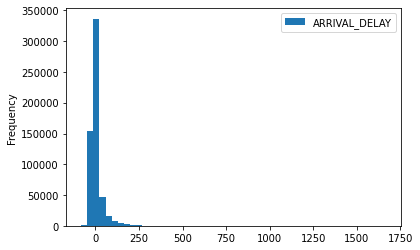

In [18]:
# Explore data distribution of ARRIVAL_DELAY
flightsDf[['ARRIVAL_DELAY']].toPandas().plot.hist(bins = 50)

<AxesSubplot:ylabel='Frequency'>

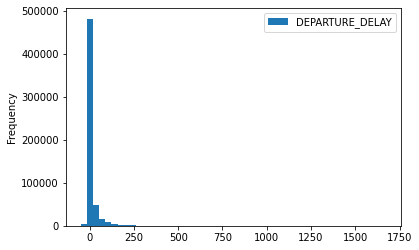

In [19]:
# Explore data distribution of DEPARTURE_DELAY
flightsDf[['DEPARTURE_DELAY']].toPandas().plot.hist(bins = 50)

In [20]:
# Create the auto label function
def auto_label(flightsDf,min_of_arr_ontime, max_of_arr_ontime,min_of_dep_ontime,max_of_dep_ontime):
    
    flightsDf = flightsDf.withColumn('multiClassArrDelay',
                     when(col('ARRIVAL_DELAY') < min_of_arr_ontime,0)\
                     .when((col('ARRIVAL_DELAY') >= min_of_arr_ontime)
                           & (col('ARRIVAL_DELAY') <= max_of_arr_ontime), 1)\
                     .otherwise(2))


    flightsDf = flightsDf.withColumn('multiClassDeptDelay',
                     when(col('DEPARTURE_DELAY') < min_of_dep_ontime,0)\
                     .when((col('DEPARTURE_DELAY') >= min_of_dep_ontime)
                           & (col('DEPARTURE_DELAY') <= max_of_dep_ontime), 1)\
                     .otherwise(2))
    return flightsDf

In [21]:
# The hyperparameters obtained from data exploration

# Q1 of arrival delay as a minimum threshold for ontime status
min_of_arr_ontime = -13

# Q3 of arrival delay as a maximum threshold for ontime status
max_of_arr_ontime  = 8

# Q1 of departure delay as a minimum threshold for ontime status
min_of_dep_ontime = -5

# Q3 of departure delay as a minimum threshold for ontime status
max_of_dep_ontime = 7

# Apply the function
flightsDf = auto_label(flightsDf,min_of_arr_ontime,
                       max_of_arr_ontime,min_of_dep_ontime,max_of_dep_ontime)

In [22]:
# Check the number of each class occurance
flightsDf.groupBy('multiClassArrDelay').count().show()

+------------------+------+
|multiClassArrDelay| count|
+------------------+------+
|                 1|294915|
|                 2|137948|
|                 0|138866|
+------------------+------+



In [23]:
# Show the labels with delays
flightsDf[['binaryArrDelay','ARRIVAL_DELAY','binaryDeptDelay','DEPARTURE_DELAY'
           ,'multiClassArrDelay','multiClassDeptDelay']].toPandas().head(20)

,binaryArrDelay,ARRIVAL_DELAY,binaryDeptDelay,DEPARTURE_DELAY,multiClassArrDelay,multiClassDeptDelay
0,0,-15,0,-1,0,1
1,0,-22,0,-3,0,1
2,0,-6,0,-1,1,1
3,0,-4,1,1,1,1
4,0,-9,0,-8,1,0
5,0,-3,0,-3,1,1
6,0,-14,0,-6,0,0
7,0,-10,0,-9,1,0
8,1,10,1,16,2,2
9,1,40,1,25,2,2


Answer

The objective of creating auto_label function is to automatically generate labels, which determine delay status (early,ontime and late). This brings to the question about how to set the criteria in each label. By setting adjustable criteria, we need to determine which hyperparameters that users can interact with the function and in this case, we select minimum and maximum delay times (both arrival and departure) for ontime status not the bin size. Using the equal bin size in each status might not be appropriate due to the left skewed distribution of delay data, which is not uniform distribution. Next, we need to determine what criteria should we use for labeling. After data exploration, there are some extreme values that signigficantly affect mean and standard deviation, so they might not be the good measurements for the criteria. Instead, we use quartiles as thresholds. If the delay times are less than Q2 (-13 for arrival delay and -5 for department delay),they are considered as early status.On the contrary, if the delay times are greater than Q3 (8 for arrival delay and 7 for department delay), they are in late status. The values between Q1 and Q3 are labelled as ontime. After getting these numbers from statistics, the thresholds illustrate the logical sense in this context.

## 1.4 Data Exploration / Exploratory Analysis (10%) <a class="anchor" id="1.4"></a>

1. Show the basic statistics (count mean stdev, min, max, 25 and 75 percentile) for all
columns of the flightsDf. Observe the mean value of each column in flightsDf. You
may see that a column like ‘AIRLINE’ does not have any mean value. You may see
that a column has a mean value equal to zero (0). Keep in mind that this analysis is
needed further to determine the selected features to build the machine learning
models. You can restrict your analysis to numerical columns only.

In [24]:
# Select only numerical columns
num_col = [column[0] for column in flightsDf.dtypes if column[1] != 'string'  ]
# Show the basic statistics
flightsDf[num_col].toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
YEAR,571729.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,571729.0,6.542260,3.398908,1.0,4.0,7.0,9.0,12.0
DAY,571729.0,15.711267,8.768838,1.0,8.0,16.0,23.0,31.0
DAY_OF_WEEK,571729.0,3.932858,1.984087,1.0,2.0,4.0,6.0,7.0
FLIGHT_NUMBER,571729.0,2160.621280,1752.191061,1.0,727.0,1678.0,3202.0,7438.0
SCHEDULED_DEPARTURE,571729.0,1328.704886,483.322122,1.0,916.0,1325.0,1730.0,2359.0
DEPARTURE_TIME,571729.0,1334.714510,496.152643,1.0,921.0,1330.0,1740.0,2400.0
DEPARTURE_DELAY,571729.0,9.323501,37.430095,-48.0,-5.0,-2.0,7.0,1670.0
TAXI_OUT,571729.0,16.076809,8.921954,1.0,11.0,14.0,19.0,200.0
WHEELS_OFF,571729.0,1357.015107,497.697168,1.0,935.0,1343.0,1754.0,2400.0


Note from basic statistics table above

- FLIGHT_NUMBER should be considered as categorical value not numerical value since the value of this data does not have order
- SCHEDULED_DEPARTURE, DEPARTURE_TIME, WHEELS_OFF,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME should be considered as timestamp

Therefore, the statistics shown in the above table is not meaningful for the mentioned columns

2. For categorical columns identify total unique categories, and category name, andfrequency of the highest occurring category in the data.

In [25]:
# Select only non-numerical columns
nonnum_col = [column[0] for column in flightsDf.dtypes if column[1] == 'string'  ]

# Show the categorical statistics
flightsDf[nonnum_col].toPandas().describe().transpose()

,count,unique,top,freq
AIRLINE,571729,14,WN,123912
TAIL_NUMBER,571729,4802,N480HA,398
ORIGIN_AIRPORT,571729,625,ATL,34506
DESTINATION_AIRPORT,571729,624,ATL,34087


3. Write code to display a histogram to show the task as follows:

a.Percentage of flights that arrive late each month

b.Percentage of flights that arrive late each day of week

c.Percentage of delayed flights by airline

In [26]:
# Preprocess data before ploting
import pyspark.sql.functions as F

# Count number of late flight
late_flight = flightsDf.filter(flightsDf.binaryArrDelay ==1)

####### a.Percentage of flights that arrive late each month ##########
# Find the number of late flight group by month
monthly_late_flight = late_flight.groupBy(F.col('MONTH')).agg(F.count('FLIGHT_NUMBER').alias('Total_late'))

# Find the number of total flight group by month
monthly_total_flight = flightsDf.groupBy(F.col('MONTH')).agg(F.count('FLIGHT_NUMBER').alias('Total_flight'))

# Join two tables above
joined_monthly_late_flight = monthly_late_flight.join(monthly_total_flight,
                                                     monthly_late_flight.MONTH == monthly_total_flight.MONTH,
                                                     how = 'inner')\
                                                .select(monthly_late_flight.MONTH,monthly_late_flight.Total_late
                                                        ,monthly_total_flight.Total_flight)

# Calculate Percentage of flights that arrive late each month
joined_monthly_late_flight = joined_monthly_late_flight.withColumn('Percentage',
                                                                   col('Total_late')/col('Total_flight')*100)\
                                                        .select('MONTH','Percentage')
# Sort by Month
joined_monthly_late_flight = joined_monthly_late_flight.sort(joined_monthly_late_flight.MONTH)

####### b.Percentage of flights that arrive late each day of week ##########

# Find the number of late flight group by day of week
dof_late_flight = late_flight.groupBy(F.col('DAY_OF_WEEK')).agg(F.count('FLIGHT_NUMBER').alias('Total_late'))

# Find the number of total flight group by day of week
dof_total_flight = flightsDf.groupBy(F.col('DAY_OF_WEEK')).agg(F.count('FLIGHT_NUMBER').alias('Total_flight'))

# Join two tables above
joined_dof_late_flight = dof_late_flight.join(dof_total_flight,
                                                     dof_late_flight.DAY_OF_WEEK == dof_total_flight.DAY_OF_WEEK,
                                                     how = 'inner')\
                                                .select(dof_late_flight.DAY_OF_WEEK,dof_late_flight.Total_late
                                                        ,dof_total_flight.Total_flight)

# Calculate Percentage of flights that arrive late each day of week
joined_dof_late_flight = joined_dof_late_flight.withColumn('Percentage',
                                                                   col('Total_late')/col('Total_flight')*100)\
                                                        .select('DAY_OF_WEEK','Percentage')

# Sort by day of week
joined_dof_late_flight = joined_dof_late_flight.sort(joined_dof_late_flight.DAY_OF_WEEK)

####### c.Percentage of delayed flights by airline ##########

# Find the number of late flight group by airline
airline_late_flight = late_flight.groupBy(F.col('AIRLINE')).agg(F.count('FLIGHT_NUMBER').alias('Total_late'))


# # Calculate Percentage of flights that arrive late each airline
airline_late_flight = airline_late_flight.withColumn('Percentage',
                                                                   (col('Total_late')/late_flight.count())*100)\
                                                        .select('AIRLINE','Percentage')
# Sort by percentage
airline_late_flight = airline_late_flight.sort(airline_late_flight.Percentage,ascending = False)

a.Percentage of flights that arrive late each month


<AxesSubplot:xlabel='MONTH'>

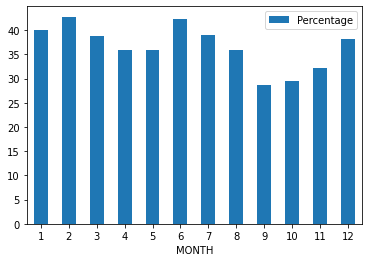

In [27]:
# a.Percentage of flights that arrive late each month'
print('a.Percentage of flights that arrive late each month')
joined_monthly_late_flight.toPandas().plot.bar(x='MONTH', y='Percentage', rot=0)

b.Percentage of flights that arrive late each day of week


<AxesSubplot:xlabel='DAY_OF_WEEK'>

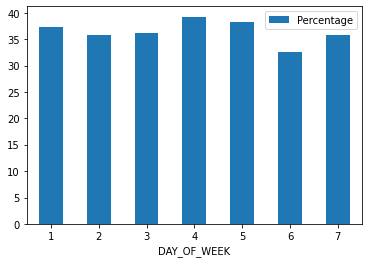

In [28]:
# b.Percentage of flights that arrive late each day of week
print('b.Percentage of flights that arrive late each day of week')
joined_dof_late_flight.toPandas().plot.bar(x='DAY_OF_WEEK', y='Percentage', rot=0)

c.Percentage of delayed flights by airline


<AxesSubplot:xlabel='AIRLINE'>

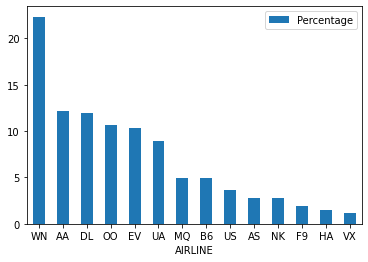

In [29]:
# c.Percentage of delayed flights by airline
print('c.Percentage of delayed flights by airline')
airline_late_flight.toPandas().plot.bar(x='AIRLINE', y='Percentage', rot=0)

# 2.Feature extraction and ML Training (55%)<a class="anchor" id="2"></a>

In this section, you will need to use PySpark DataFrame functions and ML packages
for data preparation, model building and evaluation. Other ML packages such as scikit
learn would receive zero marks. Excessive usage of Spark SQL is discouraged.

## 2.1 Discuss the feature selection and prepare the feature columns (10%) <a class="anchor" id="2.1"></a>

1. Related to the question on 1.4.1, discuss which features are likely to be feature
columns and which ones are not. Further, obtain the correlation table (use default
‘pearson’ correlation) which shows the correlation between features and labels. How
would you analyze the correlation for categorical columns? For the discussion, please
provide 300-500 words of description.

- 2.1.1 which features are likely to be feature columns and which ones are not?

Firstly, we have to understand the objective of the predictive task and data description (learn from the given data dictionary) to avoid data leakage problem. Since we want to predict whether the flight is delay or not (Label in the previous section), we exlude some features that do not know in advance including ARRIVAL_DELAY, DEPARTURE_DELAY, ARRIVAL_TIME, WHEELS_ON,TAXI_IN, DEPARTURE_TIME, TAXI_OUT, WHEELS_OFF, AIR_TIME and ELAPSED_TIME.

Then, we exclude the columns that contain high number of missing value, which are CANCELLATION_REASON,WEATHER_DELAY,LATE_AIRCRAFT_DELAY,AIRLINE_DELAY,SECURITY_DELAY and AIR_SYSTEM_DELAY (Already removed in 1.2).

After that, we remove columns that contain only one unique value, which are YEAR,DIVERTED,CANCELLED because they do not provide any additional information

Finally,FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT and DESTINATION_AIRPORT are excluded because they contain many unique values.Including these features will largely increase the number of dimensions. 

Moreover, we design to do feature extraction from the MONTH column to get SEASON column, SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL to get SCHEDULED_DEPARTURE_HOUR,SCHEDULED_DEPARTURE_daypart,SCHEDULED_ARRIVAL,SCHEDULED_ARRIVAL_daypart,and DAY_OF_WEEK to get is_weekend column

- 2.1.2 Further, obtain the correlation table (use default ‘pearson’ correlation) (Show in the correlation table belown)

After we do some feature selection and engineering, we plot the correlation table to look at linear correlation between label and features, and between features with features. As a result, there is no strong linear correlation between label and features. That's why we will use decision tree and gradient decent boosting models to predict the labels, which do not assume linear relationship between features and label.


- 2.1.3 How would you analyze the correlation for categorical columns?

Unfortunately, we cannot use pearson correlation for the caterical variable so we have to seek for alternatives. One way to detect relationship between categorical label and features is Pearson’s Chi-Square Test. This method checks independence between categorical variables. we set H₀ to be 'there is no relationship between feature and label' and if p-value is less than 0.05,we reject this hypothesis. In addition, we use Cramer's V to quantify strength of association between two nominal variables, where 0  indicates no association between the two variables and 1 indicates a strong association between the two variables. The process is shown in the code below (2.1.3)


In [30]:
########## 2.1.1 Feature Engineer for Datetime data ##########
import pyspark.sql.functions as F

### 1. Time data (SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL) ###

# 1.1 Change data type to string in order to do lpad
flightsDf= flightsDf.withColumn("SCHEDULED_DEPARTURE", 
                                flightsDf["SCHEDULED_DEPARTURE"].cast("string"))\
            .withColumn("SCHEDULED_ARRIVAL", flightsDf["SCHEDULED_ARRIVAL"].cast("string"))

# 1.2 Use lpad to fill 0            
flightsDf= flightsDf.withColumn("SCHEDULED_DEPARTURE",
                                F.lpad(flightsDf["SCHEDULED_DEPARTURE"], 4, '0'))\
    .withColumn("SCHEDULED_DEPARTURE_HOUR",F.substring('SCHEDULED_DEPARTURE',1,2))\
    .withColumn("SCHEDULED_ARRIVAL",F.lpad(flightsDf["SCHEDULED_ARRIVAL"], 4, '0'))\
    .withColumn("SCHEDULED_ARRIVAL_HOUR",F.substring('SCHEDULED_ARRIVAL',1,2))\

# 1.3 Extract hours
flightsDf= flightsDf.withColumn("SCHEDULED_DEPARTURE_HOUR",
                                flightsDf["SCHEDULED_DEPARTURE_HOUR"].cast("integer"))

flightsDf= flightsDf.withColumn("SCHEDULED_ARRIVAL_HOUR",
                                flightsDf["SCHEDULED_ARRIVAL_HOUR"].cast("integer"))

# 1.4 Create dayparts feature
flightsDf= flightsDf.withColumn('SCHEDULED_DEPARTURE_daypart',
               when((col('SCHEDULED_DEPARTURE_HOUR') >= 2) & 
                    (col('SCHEDULED_DEPARTURE_HOUR') <= 5), "dawn")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 6) &
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 9), "morning")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 10) & 
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 13), "noon")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 14) & 
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 17), "afternoon")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 18) & 
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 21), "evening")\
             .otherwise("midnight"))\
    .withColumn('SCHEDULED_ARRIVAL_daypart',
                   when((col('SCHEDULED_ARRIVAL_HOUR') >= 2) &
                        (col('SCHEDULED_ARRIVAL_HOUR') <= 5), "dawn")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 6) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 9), "morning")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 10) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 13), "noon")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 14) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 17), "afternoon")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 18) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 21), "evening")\
                 .otherwise("midnight"))

### 2. Month data (create season feature) ###

flightsDf= flightsDf.withColumn('SEASON',when((col('MONTH') >= 3) & (col('MONTH') <= 5),'Spring')\
                             .when((col('MONTH') >= 6) & (col('MONTH') <= 8),'Summer')\
                             .when((col('MONTH') >= 9) & (col('MONTH') <= 11),'Autumn')\
                             .otherwise('Winter'))

### 3. day of week data (create is_weekend feature) ###

flightsDf= flightsDf.withColumn('is_weekend',
                                when((col('DAY_OF_WEEK') == 6) | (col('DAY_OF_WEEK') == 7),1)\
                             .otherwise(0))

In [31]:
# 2.1.2 Create  ‘pearson’ correlation table for 
# numerical continuous variables after excluding features
flightsDf[['MONTH','DAY','DAY_OF_WEEK','SCHEDULED_ARRIVAL_HOUR',
           'SCHEDULED_DEPARTURE_HOUR', 'DISTANCE',
           'SCHEDULED_TIME','ARRIVAL_DELAY','DEPARTURE_DELAY']].toPandas()\
            .corr(method='pearson').style.background_gradient(cmap='coolwarm')

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_DEPARTURE_HOUR,DISTANCE,SCHEDULED_TIME,ARRIVAL_DELAY,DEPARTURE_DELAY
MONTH,1.000000,0.004354,-0.011835,-0.012048,-0.000778,0.010167,0.009833,-0.036217,-0.021136
DAY,0.004354,1.000000,0.001057,-0.001654,-0.001150,0.003293,0.003074,-0.003873,-0.001327
DAY_OF_WEEK,-0.011835,0.001057,1.000000,0.005459,0.006477,0.017207,0.015879,-0.015288,-0.009496
SCHEDULED_ARRIVAL_HOUR,-0.012048,-0.001654,0.005459,1.000000,0.707576,0.026795,0.031020,0.087395,0.096047
SCHEDULED_DEPARTURE_HOUR,-0.000778,-0.001150,0.006477,0.707576,1.000000,-0.012177,-0.019246,0.098460,0.108026
DISTANCE,0.010167,0.003293,0.017207,0.026795,-0.012177,1.000000,0.984416,-0.023812,0.024531
SCHEDULED_TIME,0.009833,0.003074,0.015879,0.031020,-0.019246,0.984416,1.000000,-0.028549,0.027801
ARRIVAL_DELAY,-0.036217,-0.003873,-0.015288,0.087395,0.098460,-0.023812,-0.028549,1.000000,0.945931
DEPARTURE_DELAY,-0.021136,-0.001327,-0.009496,0.096047,0.108026,0.024531,0.027801,0.945931,1.000000


In [32]:
# 2.1.3 Analyze relationship between catogorical variable
# source: https://www.statology.org/cramers-v-in-python/ for 'How to Calculate Cramer’s V in Python'
# source: https://towardsdatascience.com/how-to-test-for-statistically-significant-relationships-between-categorical-variables-with-chi-66c3ebeda7cc
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

raw_df = flightsDf.toPandas()

labels=['binaryArrDelay','binaryArrDelay','multiClassArrDelay','multiClassDeptDelay']
cat_features = ['AIRLINE','SEASON','SCHEDULED_DEPARTURE_daypart','SCHEDULED_ARRIVAL_daypart']

for label in labels:
    for feature in cat_features:
        # Create cross tab
        print('############ Label = ',label, ', Feature = ',feature,'############')
        crosstable = pd.crosstab(raw_df[label],raw_df[feature])
        print(crosstable)
        
        chiVal, pVal, df, exp = chi2_contingency(crosstable)
        print('If P-value is less than 0.05, we reject null hypothesis.In other word, two variables are not independent')
        print('')
        print('P-value of Chi-square is ',pVal)

        n = np.sum(np.sum(crosstable,axis=1))
        minDim = min(crosstable.shape)-1

        #calculate Cramer's V 
        V = np.sqrt((chiVal/n) / minDim)

        print('')
        print('Cramer s V: ',V)
        print('')


############ Label =  binaryArrDelay , Feature =  AIRLINE ############
AIRLINE            AA     AS     B6     DL     EV    F9    HA     MQ    NK  \
binaryArrDelay                                                               
0               45891  11508  16010  62309  33833  4899  4573  17503  5811   
1               25351   5778  10276  24998  21516  4121  3097  10396  5711   

AIRLINE            OO     UA     US    VX     WN  
binaryArrDelay                                    
0               35406  32216  11877  3631  77207  
1               22259  18736   7642  2469  46705  
If P-value is less than 0.05, we reject null hypothesis.In other word, two variables are not independent

P-value of Chi-square is  0.0

Cramer s V:  0.08526636142134753

############ Label =  binaryArrDelay , Feature =  SEASON ############
SEASON          Autumn  Spring  Summer  Winter
binaryArrDelay                                
0                98541   92613   91695   79825
1                42478   54165

2. Write the code to create the analytical dataset consisting of relevant columns based on
your discussion above

Some feature engineers are done in the previous part before ploting correlation plot 

In [33]:
# Select columns after excluding and including some columns
include_features = ['MONTH','DAY','DAY_OF_WEEK','AIRLINE',
                 'SCHEDULED_ARRIVAL_HOUR','SCHEDULED_TIME','DISTANCE','SCHEDULED_DEPARTURE_HOUR',
                 'SEASON','is_weekend','SCHEDULED_DEPARTURE_daypart','SCHEDULED_ARRIVAL_daypart',
                    'binaryArrDelay','binaryDeptDelay','multiClassArrDelay','multiClassDeptDelay']

cleaned_flightsDf = flightsDf[include_features]


## 2.2 Preparing any Spark ML Transformers/ Estimators for features and models(10-15%) <a class="anchor" id="2.2"></a>

1. Write code to create Transformers/Estimators for transforming/assembling the
columns you selected above in 2.1.

In [34]:
# Define columns that are numerical and categorical, which we want to use as features
numerical_col = ['DISTANCE','SCHEDULED_TIME','MONTH','DAY','DAY_OF_WEEK','is_weekend',
                'SCHEDULED_ARRIVAL_HOUR','SCHEDULED_DEPARTURE_HOUR']

categorical_col = ['AIRLINE','SEASON','SCHEDULED_DEPARTURE_daypart','SCHEDULED_ARRIVAL_daypart']

In [35]:
# 1.String Indexer

from pyspark.ml.feature import StringIndexer

# input for String Indexer
inputCols = categorical_col
print(inputCols)

# output for String Indexer
outputCols = [f'{x}_index' for x in inputCols]
print(outputCols)

# String Index
stringIndex = StringIndexer(inputCols=inputCols, outputCols=outputCols)


['AIRLINE', 'SEASON', 'SCHEDULED_DEPARTURE_daypart', 'SCHEDULED_ARRIVAL_daypart']
['AIRLINE_index', 'SEASON_index', 'SCHEDULED_DEPARTURE_daypart_index', 'SCHEDULED_ARRIVAL_daypart_index']


In [36]:
# 2. One hot endoder
from pyspark.ml.feature import OneHotEncoder

# Input for OHE = Output for String Indexer
inputCols_OHE = outputCols
print(inputCols_OHE)

# output columns for OHE
outputCols_OHE = [f'{x}_vec' for x in inputCols_OHE ]
print(outputCols_OHE)

# One hot encoder
OneHotEncoder = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)


['AIRLINE_index', 'SEASON_index', 'SCHEDULED_DEPARTURE_daypart_index', 'SCHEDULED_ARRIVAL_daypart_index']
['AIRLINE_index_vec', 'SEASON_index_vec', 'SCHEDULED_DEPARTURE_daypart_index_vec', 'SCHEDULED_ARRIVAL_daypart_index_vec']


In [37]:
# 3. Vector Assembler
from pyspark.ml.feature import VectorAssembler

# Input = output for stage three + numerical data
inputCols_VE = outputCols_OHE + numerical_col
print(inputCols_VE)

#VectorAssembler
VectorAssembler = VectorAssembler(inputCols=inputCols_VE, outputCol="features")

['AIRLINE_index_vec', 'SEASON_index_vec', 'SCHEDULED_DEPARTURE_daypart_index_vec', 'SCHEDULED_ARRIVAL_daypart_index_vec', 'DISTANCE', 'SCHEDULED_TIME', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'is_weekend', 'SCHEDULED_ARRIVAL_HOUR', 'SCHEDULED_DEPARTURE_HOUR']


2. Bonus task: (5%)
Create a Custom Transformer that allows you to map Months to Season. Note the
Custom Transformer can be used with the pipeline. E.g. Months 3 to 5 are mapped as
“Spring”, Months 6 to 8 are mapped as “Summer”, Months 9 to 11 are mapped as
“Autumn”, and Months 12, 1, and 2 are mapped as “Winter”

In [38]:
# Already included season in the previous part

3. Create ML model Estimators for Decision Tree and Gradient Boosted Tree model for
binary classification for both arrival and departure delays (PLEASE DO NOT
fit/transform the data yet).

In [39]:
# Decision Tree model
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassifier


# Create Decision tree model for binaryArrDelay
dt_arr = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'binaryArrDelay', maxDepth = 5)

# Create Decision tree model for binaryDeptDelay
dt_dep = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'binaryDeptDelay', maxDepth = 5)

In [40]:
# Gradient Boosted Tree model
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import GBTClassifier

# Create Gradient Boosted Tree model model for binaryArrDelay
gbt_arr =GBTClassifier(featuresCol = 'features', labelCol = 'binaryArrDelay',  maxIter=10)

# Create Gradient Boosted Tree model model for binaryDeptDelay
gbt_dep =GBTClassifier(featuresCol = 'features', labelCol = 'binaryDeptDelay',  maxIter=10)

4. Create ML model Estimators for Naive Bayes model for multiclass classification for
both arrival and departure delays from the labels that you have created at task 1.2
(PLEASE DO NOT fit/transform the data yet).

In [41]:
# Naive Bayes 

from pyspark.ml.classification import NaiveBayes

# Create Naive Bayes model model for multiClassArrDelay
nb_arr = NaiveBayes(featuresCol = 'features', labelCol = 'multiClassArrDelay',
                    smoothing=1.0, modelType="multinomial")

# Create Naive Bayes model model for multiClassDeptDelay
nb_dep = NaiveBayes(featuresCol = 'features', labelCol = 'multiClassDeptDelay',
                    smoothing=1.0, modelType="multinomial")


5. Write code to include the above Transformers/Estimators into pipelines for all tasks
(PLEASE DO NOT fit/transform the data yet).

In [42]:
# Pipeline
from pyspark.ml import Pipeline

#plug the stages into the pipline
# pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler])


# Create pipeline to all models
dt_arr_pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler,dt_arr])
dt_dep_pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler,dt_dep])
gbt_arr_pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler,gbt_arr])
gbt_dep_pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler,gbt_dep])
nb_arr_pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler,nb_arr])
nb_dep_pipeline = Pipeline(stages=[stringIndex, OneHotEncoder, VectorAssembler,nb_dep])

## 2.3 Preparing the training and testing data (5%)<a class="anchor" id="2.3"></a>

1. Write code to randomly split the data into 80 percent and 20 percent proportion as
training and testing data. You may use seed for the analysis purposes. This training
and testing data will be used for model evaluation of all tasks in 2.4.

In [43]:
#Split train and test
train, test =cleaned_flightsDf.randomSplit([0.8,0.2], seed =555)

## 2.4 Training and evaluating models (30%)<a class="anchor" id="2.4"></a>

For three use cases below, please follow the instructions.

#### 1. Binary classification task (Using Decision Tree and Gradient Boosted Tree) for both arrival and departure delay classification (4 models).

a. Write code to use the corresponding ML Pipelines to train the models on the
training data.

In [44]:
# Transform data and Train decision tree model on training dataset

dt_arr_model = dt_arr_pipeline.fit(train)
dt_dep_model = dt_dep_pipeline.fit(train)

In [45]:
# Transform data and Train Gradient Boosted Tree model on training dataset
gbt_arr_model = gbt_arr_pipeline.fit(train)
gbt_dep_model = gbt_dep_pipeline.fit(train)

In [46]:
# Predict on testing data
dt_arr_prediction= dt_arr_model.transform(test)
dt_dep_prediction= dt_dep_model.transform(test)
gbt_arr_prediction= gbt_arr_model.transform(test)
gbt_dep_prediction= gbt_dep_model.transform(test)


b. For both models and for both delays, write code to display the count of each
combination of late/not late label and prediction label in formats as shown in
the example Fig.1.

In [47]:
# Create count table for binaryArrDelay for decision tree model
dt_arr_prediction.groupBy('binaryArrDelay', 'prediction').count().show()


+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|39513|
|             0|       0.0|70321|
|             1|       1.0| 2524|
|             0|       1.0| 2039|
+--------------+----------+-----+



In [48]:
# Create count table for binaryDeptDelay for decision tree model
dt_dep_prediction.groupBy('binaryDeptDelay', 'prediction').count().show()

+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|32340|
|              0|       0.0|65406|
|              1|       1.0|10070|
|              0|       1.0| 6581|
+---------------+----------+-----+



In [49]:
# Create count table for binaryArrDelay for Gradient Boosted Tree model 
gbt_arr_prediction.groupBy('binaryArrDelay', 'prediction').count().show()

+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|37592|
|             0|       0.0|69340|
|             1|       1.0| 4445|
|             0|       1.0| 3020|
+--------------+----------+-----+



In [50]:
# Create count table for binaryDeptDelay for Gradient Boosted Tree model 
gbt_dep_prediction.groupBy('binaryDeptDelay', 'prediction').count().show()

+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|31423|
|              0|       0.0|65026|
|              1|       1.0|10987|
|              0|       1.0| 6961|
+---------------+----------+-----+



c. Compute the AUC, accuracy, recall, and precision for the late/not late label
from each model testing result using pyspark MLlib/ML APIs.

In [51]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use MulticlassClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

############# AUC #############
arr_auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                                  labelCol='binaryArrDelay')
dep_auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                                  labelCol='binaryDeptDelay')

### Arrival delay ###

# Decision Tree Model
dt_arr_auc = arr_auc_evaluator.evaluate(dt_arr_prediction)

# Gradient Boosted Tree Model
gbt_arr_auc = arr_auc_evaluator.evaluate(gbt_arr_prediction)

### Departure delay ###

# Decision Tree Model
dt_dep_auc = dep_auc_evaluator.evaluate(dt_dep_prediction)

# Gradient Boosted Tree Model
gbt_dep_auc = dep_auc_evaluator.evaluate(gbt_dep_prediction)

print('-------------------AUC-------------------')
print('')      
print('-------Arrival Delay-------')
print('Decision Tree Model: ',dt_arr_auc)
print('Gradient Boosted Tree Model: ',gbt_arr_auc)
print('') 
print('-------Departure Delay-------')
print('Decision Tree Model: ',dt_dep_auc)
print('Gradient Boosted Tree Model: ',gbt_dep_auc)
print('') 

############# Accuracy #############
arr_accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',
                                                           labelCol='binaryArrDelay',
                                                           metricName = 'accuracy')

dep_accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',
                                                           labelCol='binaryDeptDelay',
                                                           metricName = 'accuracy')

### Arrival delay ###

# Decision Tree Model
dt_arr_accuracy = arr_accuracy_evaluator.evaluate(dt_arr_prediction)

# Gradient Boosted Tree Model
gbt_arr_accuracy = arr_accuracy_evaluator.evaluate(gbt_arr_prediction)

### Departure delay ###

# Decision Tree Model
dt_dep_accuracy = dep_accuracy_evaluator.evaluate(dt_dep_prediction)

# Gradient Boosted Tree Model
gbt_dep_accuracy = dep_accuracy_evaluator.evaluate(gbt_dep_prediction)

print('-------------------Accuracy-------------------')
print('') 
print('-------Arrival Delay-------') 
print('Decision Tree Model: ',dt_arr_accuracy)
print('Gradient Boosted Tree Model: ',gbt_arr_accuracy)
print('') 
print('-------Departure Delay-------')
print('Decision Tree Model: ',dt_dep_accuracy)
print('Gradient Boosted Tree Model: ',gbt_dep_accuracy)
print('') 

############# Recall #############
arr_recall_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', 
                                                         labelCol='binaryArrDelay',
                                                           metricName = 'recallByLabel')
dep_recall_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', 
                                                         labelCol='binaryDeptDelay',
                                                           metricName = 'recallByLabel')

### Arrival delay ###

# Decision Tree Model
dt_arr_recall = arr_recall_evaluator.evaluate(dt_arr_prediction)

# Gradient Boosted Tree Model
gbt_arr_recall = arr_recall_evaluator.evaluate(gbt_arr_prediction)

### Departure delay ###

# Decision Tree Model
dt_dep_recall = dep_recall_evaluator.evaluate(dt_dep_prediction)

# Gradient Boosted Tree Model
gbt_dep_recall = dep_recall_evaluator.evaluate(gbt_dep_prediction)

print('-------------------Recall-------------------')
print('') 
print('-------Arrival Delay-------')
print('Decision Tree Model: ',dt_arr_recall)
print('Gradient Boosted Tree Model: ',gbt_arr_recall)
print('') 
print('-------Departure Delay-------')
print('Decision Tree Model: ',dt_dep_recall)
print('Gradient Boosted Tree Model: ',gbt_dep_recall)
print('') 

############# Precision #############
arr_precision_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', 
                                                            labelCol='binaryArrDelay',
                                                           metricName = 'precisionByLabel')
dep_precision_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', 
                                                            labelCol='binaryDeptDelay',
                                                           metricName = 'precisionByLabel')

### Arrival delay ###

# Decision Tree Model
dt_arr_precision = arr_precision_evaluator.evaluate(dt_arr_prediction)

# Gradient Boosted Tree Model
gbt_arr_precision = arr_precision_evaluator.evaluate(gbt_arr_prediction)

### Departure delay ###

# Decision Tree Model
dt_dep_precision = dep_precision_evaluator.evaluate(dt_dep_prediction)

# Gradient Boosted Tree Model
gbt_dep_precision = dep_precision_evaluator.evaluate(gbt_dep_prediction)

print('-------------------Precision-------------------')
print('') 
print('-------Arrival Delay-------')
print('Decision Tree Model: ',dt_arr_precision)
print('Gradient Boosted Tree Model: ',gbt_arr_precision)
print('') 
print('-------Departure Delay-------')
print('Decision Tree Model: ',dt_dep_precision)
print('Gradient Boosted Tree Model: ',gbt_dep_precision)
print('') 

-------------------AUC-------------------

-------Arrival Delay-------
Decision Tree Model:  0.44308385724397975
Gradient Boosted Tree Model:  0.6274819166781306

-------Departure Delay-------
Decision Tree Model:  0.5168939119837086
Gradient Boosted Tree Model:  0.6715966875611598

-------------------Accuracy-------------------

-------Arrival Delay-------
Decision Tree Model:  0.6367736916177872
Gradient Boosted Tree Model:  0.6449906903153054

-------Departure Delay-------
Decision Tree Model:  0.6597725464828623
Gradient Boosted Tree Model:  0.664466725526019

-------------------Recall-------------------

-------Arrival Delay-------
Decision Tree Model:  0.9718214483139856
Gradient Boosted Tree Model:  0.9582642343836374

-------Departure Delay-------
Decision Tree Model:  0.9085807159626044
Gradient Boosted Tree Model:  0.9033019850806395

-------------------Precision-------------------

-------Arrival Delay-------
Decision Tree Model:  0.6402480106342299
Gradient Boosted Tree Mod

d. Discuss which metric is more proper for measuring the model performance on
predicting late/not late events, in order to give the performers good
recommendations.

Answer

AUC is likely to be more proper measurement to assess model performance since  AUC incoporates different aspects into a single number. Those aspects are sensitivity and specificity for all threshold level. Recall (TP/(TP+FN)) and precision (TP/(TP+FP)) consider only one perspective, while accuracy is the proportion of correct classifications among all classifications, which might not be appropriate in some cases, especially when the distribution of labels is unbalance. As a result, AUC is more proper to give the performers good recommendations



e. Discuss which is the better model, and persist the better model.

Answer

Gradient Boosted Tree models for both arrival and departure delays are better because they give higher AUC than those in decision tree models. Also, Gradient Boosted Tree model uses ensembling technique, which combines several tree sequentially learned from previous decision tree mistakes. Using decision tree is unreliable and can potentially lead to overfitting problem

f. Write code to print out the leaf node splitting criteria and the top-3 features
with each corresponding feature importance. Describe the result in a way that
it could be understood by your potential users.

Show top-3 features with each corresponding feature importance

In [52]:
# Source :https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
        varlist = pd.DataFrame(list_extract)
        varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
        return(varlist.sort_values('score', ascending = False))

In [53]:
# Show top-3 features with each corresponding feature importance of arrival decision tree model.
ExtractFeatureImp(dt_arr_model.stages[-1].featureImportances,dt_arr_prediction,
                  'features')[['name','score']].head(3)

,name,score
7,SCHEDULED_DEPARTURE_HOUR,0.607665
2,MONTH,0.021732
0,DISTANCE,0.000000


In [54]:
# Show top-3 features with each corresponding feature importance of departure decision tree model.
ExtractFeatureImp(dt_dep_model.stages[-1].featureImportances,dt_dep_prediction,
                  'features')[['name','score']].head(3)

,name,score
7,SCHEDULED_DEPARTURE_HOUR,0.532545
2,MONTH,0.029397
6,SCHEDULED_ARRIVAL_HOUR,0.004575


In [55]:
# Show top-3 features with each corresponding feature importance of arrival gradient boost tree.
ExtractFeatureImp(gbt_arr_model.stages[-1].featureImportances,
                  gbt_arr_prediction,'features')[['name','score']].head(3)

,name,score
3,DAY,0.251357
2,MONTH,0.238487
7,SCHEDULED_DEPARTURE_HOUR,0.109118


In [56]:
# Show top-3 features with each corresponding feature importance of departure gradient boost tree.
ExtractFeatureImp(gbt_dep_model.stages[-1].featureImportances,
                  gbt_dep_prediction,'features')[['name','score']].head(3)

,name,score
7,SCHEDULED_DEPARTURE_HOUR,0.198143
3,DAY,0.165910
2,MONTH,0.086946


Describe the result in a way that it could be understood by your potential users.

The importance feature scores indicate how features contribute to the predictive models. The higher the score is, the important of the feature used for prediction

Show Leaf node splitting criteria

In [57]:
# Create table that refers to feature number
list_extract = []
for i in dt_arr_prediction.schema[ 'features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + dt_arr_prediction.schema[ 'features'].metadata["ml_attr"]["attrs"][i]
feature_list = pd.DataFrame(list_extract)
feature_list = feature_list.sort_values('idx')
feature_list['feature'] = [f'feature_{x}' for x in list(feature_list['idx'])]
feature_list = feature_list.reset_index()
feature_list = feature_list[['feature','name']]

In [58]:
#  leaf node splitting criteria  for arrival decision tree model
print('User can refer feature number in this table')
print('')
print(feature_list)
print('')
print('This is criteria used for tree splitting')
print('')
print(dt_arr_model.stages[3].toDebugString)

User can refer feature number in this table

       feature                                             name
0    feature_0                             AIRLINE_index_vec_WN
1    feature_1                             AIRLINE_index_vec_DL
2    feature_2                             AIRLINE_index_vec_AA
3    feature_3                             AIRLINE_index_vec_OO
4    feature_4                             AIRLINE_index_vec_EV
5    feature_5                             AIRLINE_index_vec_UA
6    feature_6                             AIRLINE_index_vec_MQ
7    feature_7                             AIRLINE_index_vec_B6
8    feature_8                             AIRLINE_index_vec_US
9    feature_9                             AIRLINE_index_vec_AS
10  feature_10                             AIRLINE_index_vec_NK
11  feature_11                             AIRLINE_index_vec_F9
12  feature_12                             AIRLINE_index_vec_HA
13  feature_13                          SEASON_index_vec_Su

In [59]:
#  leaf node splitting criteria  for departure decision tree model
print('User can refer feature number in this table')
print('')
print(feature_list)
print('')
print('This is criteria used for tree splitting')
print('')
print(dt_dep_model.stages[3].toDebugString)

User can refer feature number in this table

       feature                                             name
0    feature_0                             AIRLINE_index_vec_WN
1    feature_1                             AIRLINE_index_vec_DL
2    feature_2                             AIRLINE_index_vec_AA
3    feature_3                             AIRLINE_index_vec_OO
4    feature_4                             AIRLINE_index_vec_EV
5    feature_5                             AIRLINE_index_vec_UA
6    feature_6                             AIRLINE_index_vec_MQ
7    feature_7                             AIRLINE_index_vec_B6
8    feature_8                             AIRLINE_index_vec_US
9    feature_9                             AIRLINE_index_vec_AS
10  feature_10                             AIRLINE_index_vec_NK
11  feature_11                             AIRLINE_index_vec_F9
12  feature_12                             AIRLINE_index_vec_HA
13  feature_13                          SEASON_index_vec_Su

In [60]:
#  leaf node splitting criteria  for arrival decision tree model
print('User can refer feature number in this table')
print('')
print(feature_list)
print('')
print('This is criteria used for tree splitting')
print('')
print(gbt_arr_model.stages[3].toDebugString)

User can refer feature number in this table

       feature                                             name
0    feature_0                             AIRLINE_index_vec_WN
1    feature_1                             AIRLINE_index_vec_DL
2    feature_2                             AIRLINE_index_vec_AA
3    feature_3                             AIRLINE_index_vec_OO
4    feature_4                             AIRLINE_index_vec_EV
5    feature_5                             AIRLINE_index_vec_UA
6    feature_6                             AIRLINE_index_vec_MQ
7    feature_7                             AIRLINE_index_vec_B6
8    feature_8                             AIRLINE_index_vec_US
9    feature_9                             AIRLINE_index_vec_AS
10  feature_10                             AIRLINE_index_vec_NK
11  feature_11                             AIRLINE_index_vec_F9
12  feature_12                             AIRLINE_index_vec_HA
13  feature_13                          SEASON_index_vec_Su

In [61]:
#  leaf node splitting criteria  for arrival decision tree model
print('User can refer feature number in this table')
print('')
print(feature_list)
print('')
print('This is criteria used for tree splitting')
print('')
print(gbt_dep_model.stages[3].toDebugString)

User can refer feature number in this table

       feature                                             name
0    feature_0                             AIRLINE_index_vec_WN
1    feature_1                             AIRLINE_index_vec_DL
2    feature_2                             AIRLINE_index_vec_AA
3    feature_3                             AIRLINE_index_vec_OO
4    feature_4                             AIRLINE_index_vec_EV
5    feature_5                             AIRLINE_index_vec_UA
6    feature_6                             AIRLINE_index_vec_MQ
7    feature_7                             AIRLINE_index_vec_B6
8    feature_8                             AIRLINE_index_vec_US
9    feature_9                             AIRLINE_index_vec_AS
10  feature_10                             AIRLINE_index_vec_NK
11  feature_11                             AIRLINE_index_vec_F9
12  feature_12                             AIRLINE_index_vec_HA
13  feature_13                          SEASON_index_vec_Su

g. Discuss the ways the performance can be improved for both classifiers
(500-700 words in total)

Improving model performance can be done in several procedures starting from data collection to the end of model development process, which is hyperparameter tuning. In this discussion, we will find possible ways to enhance model performance step by step.

Firstly, one of the most famous phrase in data science society stated that 'Garbage in Garbage Out'. It is impossible to have satisfied results from models if we have limited access to quality data. Data collection is the first thing in data pipeline that we can improve to get a better model performance. In this case, we can collect more data about departure and arrival airport characteristics,number of passangers, predicted weather, staff related data (number of staffs, pilot experiences) and so on. Obtaining more related features can surprisingly improve the quality of model inputs leading to significantly enhance model performance. Not only data collection aspect, but quality of the existing data part that can help data input better. The quality of the data depends on correctness, completeness and consistency of the data, which make the features usable and represent the correct data.

Next, feature engineering step can even be improved especially when we deal with time-series data. Having datetime data is informative and serveral feature extraction steps can be performed. Even we do several feature extraction for the pipeline above, several approaches can be added. For example, we can flag whether that day is public holiday or not or we can tag daypart in different way from what we did in the previous section.

After that, in the model development so far, we only have two comparative models from decision tree and gradient decent boosting without hyperparameter tuning. In decision tree model, it is an unreliable model and tends to overfit the data. By solving decision tree problem, ensembling techniques such as random forest and gradient decent boosting can be used. Gradient Boosted Tree Model is one of the famous tree-based model used widely in Kaggle competition and usually give a satisfied results. However, proper hyperparmeter tuning should be carefully performed since there are many parameters in this model such as impurity function, maximum tree depth, learning rate, number of iteration and so on. We can use ncross validation with the range of parameter grid to find the combination of the parameters that give us the best model performance. Moreover, there is no free lunch for model development so we can try other tuned models such random forest, ada boost, lightGB, catboost, support vector machine,KNN, logistic regression, neural network and so on to either select the best model, which gives us the best model performance or use ensembling technique that we buid several models and use majority vote to predict the results.

In conclusion, model performance can be improved by enhancing several steps starting from improving input data in term of quantity and quality, then tuning existing model hyperparameter to get a better result. At the end, we can build several models and select the best model, which gives us the best performance or we can use ensembling techinique and use majority vote as a predictor.

#### 2. Multiclass classification task (Using Naive Bayes) for only arrival delay classification (1 model).

a. Write code to use the corresponding ML Pipelines to train the model on the
training data. This label is automatically generated from task 1.3.2.

In [62]:
# Train  Naive Bayes model on training dataset
nb_arr_model = nb_arr_pipeline.fit(train)

# Predict on testing data
nb_arr_prediction= nb_arr_model.transform(test)


b. Write code to display the count of each combination of early/on-time/late label
and prediction label in formats as shown in the example Fig.2.

In [63]:
# Create count table for multiClassArrDelay for Naive Bayes model
nb_arr_prediction.groupBy('multiClassArrDelay', 'prediction').count().show()

+------------------+----------+-----+
|multiClassArrDelay|prediction|count|
+------------------+----------+-----+
|                 2|       1.0|15682|
|                 1|       0.0|17953|
|                 0|       2.0| 1865|
|                 0|       0.0|11459|
|                 1|       2.0| 4386|
|                 2|       2.0| 3368|
|                 1|       1.0|36761|
|                 2|       0.0| 8593|
|                 0|       1.0|14330|
+------------------+----------+-----+



c. Compute the AUC, accuracy, recall, and precision for the early/on-time/late
label from Naive Bayes model from pyspark MLlib/ML APIs

In [64]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use MulticlassClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

############# AUC #############
arr_auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='multiClassArrDelay')
dep_auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='multiClassDeptDelay')

### Arrival delay ###

# Decision Tree Model
nb_arr_auc = arr_auc_evaluator.evaluate(nb_arr_prediction)



print('-------------------AUC-------------------')
print('')      
print('-------Arrival Delay-------')
print('Naive Bayes model: ',nb_arr_auc)
print('') 


############# Accuracy #############
arr_accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='multiClassArrDelay',
                                                           metricName = 'accuracy')


### Arrival delay ###

# Naive Bayes model 
nb_arr_accuracy = arr_accuracy_evaluator.evaluate(nb_arr_prediction)



print('-------------------Accuracy-------------------')
print('') 
print('-------Arrival Delay-------') 
print('Naive Bayes model: ',nb_arr_accuracy)
print('') 

############# Recall #############
arr_recall_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='multiClassArrDelay',
                                                           metricName = 'weightedRecall')

### Arrival delay ###

# Naive Bayes model 
nb_arr_recall = arr_recall_evaluator.evaluate(nb_arr_prediction)


print('-------------------Recall-------------------')
print('') 
print('-------Arrival Delay-------')
print('Naive Bayes model: ',nb_arr_recall)
print('') 

# ############# Precision #############
arr_precision_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='multiClassArrDelay',
                                                           metricName = 'weightedPrecision')


# ### Arrival delay ###

# Naive Bayes model 
nb_arr_precision = arr_precision_evaluator.evaluate(nb_arr_prediction)


print('-------------------Precision-------------------')
print('') 
print('-------Arrival Delay-------')
print('Naive Bayes model: ',nb_arr_precision)
print('') 

-------------------AUC-------------------

-------Arrival Delay-------
Naive Bayes model:  0.5775326725202609

-------------------Accuracy-------------------

-------Arrival Delay-------
Naive Bayes model:  0.4509558817101847

-------------------Recall-------------------

-------Arrival Delay-------
Naive Bayes model:  0.45095588171018475

-------------------Precision-------------------

-------Arrival Delay-------
Naive Bayes model:  0.4419145554227229



d. Discuss which metric is more proper for measuring the model performance on
predicting early/on-time/late events, in order to give the performers good
recommendations

Answer

AUC is likely to be more proper measurement to assess model performance since  AUC incoporates different aspects into a single number. Those aspects are sensitivity and specificity for all threshold level. Recall (TP/(TP+FN)) and precision (TP/(TP+FP)) consider only one perspective, while accuracy is the proportion of correct classifications among all classifications, which might not be appropriate in some cases, especially when the distribution of labels is unbalance. As a result, AUC is more proper to give the performers good recommendations. However, AUC in multi-label classification problem AUC is caculated in different way using OVR(One-vs-rest) or OVO (One-vs-one) to compute positive and negative rates.

source : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

e. Discuss the ways the performance can be improved for Naive Bayes classifiers
(500-700 words in total)

Improving model performance can be done in several procedures starting from data collection to the end of model development process, which has to make sure that all assumptions of the models are satisfied. In this discussion, we will find possible ways to enhance model performance step by step.

Firstly, one of the most famous phrase in data science society stated that 'Garbage in Garbage Out'. It is impossible to have satisfied results from models if we have limited access to quality data. Data collection is the first thing in data pipeline that we can improve to get a better model performance. In this case, we can collect more data about departure and arrival airport characteristics,number of passangers, predicted weather, staff related data (number of staffs, pilot experiences) and so on. Obtaining more related features can surprisingly improve the quality of model inputs leading to significantly enhance model performance. Not only data collection aspect, but quality of the existing data part that can help data input better. The quality of the data depends on correctness, completeness and consistency of the data, which make the features usable and represent the correct data. Moreover, in Naive Bayes model, it requires “naive” assumption of conditional independence between every pair of features given the value of the class variable so feature selection should be properly done beforehand unlike gradient descent boosting model, which has ability to select features by the model itself

Next, feature engineering step can even be improved especially when we deal with time-series data. Having datetime data is informative and serveral feature extraction steps can be performed. Even we do several feature extraction for the pipeline above, several approaches can be added. For example, we can flag whether that day is public holiday or not or we can tag daypart in different way from what we did in the previous section.

After that, in the model development so far, we only have one model, which is Naive Bayse in  multi-label prediction. The model has several assumptions that we have to make sure that our data satisfy those model assumptions.Otherwise, the model performance might be unreliable. Moreover, there is no free lunch for model development so we can try other multi-label classification models such tree-based, support vector machine,KNN, logistic regression, neural network and so on to either select the best model, which gives us the best model performance or use ensembling technique that we buid several models and use majority vote to predict the results.

In conclusion, model performance can be improved by enhancing several steps starting from improving input data in term of quantity and quality, then develop several models and select the best performer or we can use ensembling techinique and use majority vote as a predictor

source :https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

### Reference


Z. (2021, April 19). How to Calculate Cramer’s V in Python. Statology. https://www.statology.org/cramers-v-in-python/


Chen, L. (2020, July 1). How to Test for Statistically Significant Relationships Between Categorical Variables with Chi Square. Medium. https://towardsdatascience.com/how-to-test-for-statistically-significant-relationships-between-categorical-variables-with-chi-66c3ebeda7cc



Lin, T. (2021, January 16). Feature Selection Using Feature Importance Score - Creating a PySpark Estimator. Quasilinear Musings. https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator


sklearn.metrics.roc_auc_score — scikit-learn 0.24.2 documentation. (n.d.). Https://Scikit-Learn.Org/Stable/Modules/Generated/Sklearn.Metrics.Roc_auc_score.Html. Retrieved September 22, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html



1.9. Naive Bayes — scikit-learn 0.24.2 documentation. (n.d.). Https://Scikit-Learn.Org/Stable/Modules/Naive_bayes.Html#multinomial-Naive-Bayes. Retrieved September 22, 2021, from https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes